## Retrospective Estimator example

In [2]:
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from upliftml.models.pyspark import (
    RetrospectiveEstimator
)

from upliftml.evaluation import (
    estimate_roi,
    estimate_iroi,
    estimate_and_plot_iroi_per_bucket,
    estimate_and_plot_iroi_per_quantile,
    estimate_and_plot_cum_iroi,
    plot_metric_per_bucket,
    plot_cum_iroi
)

from upliftml.datasets import simulate_randomized_trial

### Specify plot style


In [3]:
sns.set(font_scale=1.5, style='ticks', rc={'figure.figsize':(11, 7)}) 

### Read dataframe

In [4]:
df_pd = simulate_randomized_trial(n=2000, p=6, sigma=1.0, binary_outcome=True, add_cost_benefit=True)
df_spark = spark.createDataFrame(df_pd)

In [5]:
df_spark.cache().count() 

2000

In [6]:
df_spark.limit(5).toPandas() 

,treatment,outcome,propensity,expected_outcome,actual_cate,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,benefit,cost
0,1,0,0.5,0.000000,-0.060041,-1.737576,-0.486028,-0.852931,-0.209666,-1.232401,-0.529379,0.000000,0.000000
1,0,0,0.5,0.000000,0.248387,-0.584504,-0.947664,1.370967,-1.256588,0.944933,-1.472792,0.000000,0.000000
2,1,1,0.5,0.000000,0.248844,0.333312,0.022009,-0.677174,-0.530989,-1.588610,-1.195767,3.688308,0.922077
3,1,1,0.5,2.221336,0.093305,-1.685321,1.414521,0.949599,0.191953,1.350585,-0.724823,4.348953,1.087238
4,0,1,0.5,5.892176,0.022531,2.385654,1.509790,1.996732,0.436906,-0.464525,-2.084312,2.451792,0.000000


### Estimate ROI

In [7]:
results = estimate_roi(df_spark,
                       benefit_colname='benefit',
                       cost_colname='cost',
                       bootstrap=True,
                       n_bootstraps=100,
                       ci_quantiles=[0.025, 0.975])

print('ROI: {:.4f}, lower: {:.4f}, upper: {:.4f}'.format(results['roi'], results['roi_lower'], results['roi_upper']))

ROI: 7.4640, lower: 7.0270, upper: 7.8174


### Estimate incremental ROI

In [8]:
results = estimate_iroi(df_spark,
                        benefit_colname='benefit',
                        cost_colname='cost',
                        treatment_colname='treatment',
                        treatment_value=1, 
                        control_value=0,
                        bootstrap=True,
                        n_bootstraps=100,
                        ci_quantiles=[0.025, 0.975])

print('iROI: {:.4f}, lower: {:.4f}, upper: {:.4f}'.format(results['iroi'], results['iroi_lower'], results['iroi_upper']))
print('incremental benefit: {:.4f}, lower: {:.4f}, upper: {:.4f}'.format(results['incremental_benefit'], results['incremental_benefit_lower'], results['incremental_benefit_upper']))
print('incremental cost: {:.4f}, lower: {:.4f}, upper: {:.4f}'.format(results['incremental_cost'], results['incremental_cost_lower'], results['incremental_cost_upper']))

iROI: 0.4590, lower: 0.2304, upper: 0.7349
incremental benefit: 276.7055, lower: 121.5146, upper: 454.5149
incremental cost: 602.8872, lower: 546.6350, upper: 657.1097


### iROI per segments

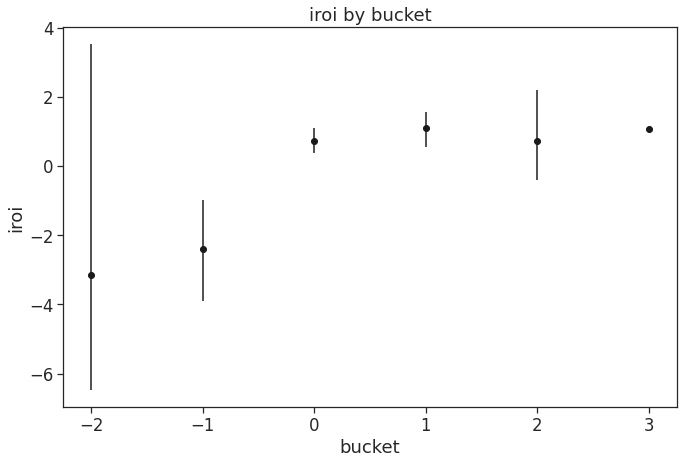

In [9]:
# Add a categorical feature 'bucket'
df_spark_with_bucket = df_spark.withColumn('bucket', F.col('feature_1').cast('int'))

df_iroi_per_bucket = estimate_and_plot_iroi_per_bucket(df_spark_with_bucket, 
                                             bucket_colname='bucket', 
                                             benefit_colname='benefit', 
                                             cost_colname='cost', 
                                             treatment_colname='treatment',
                                             bootstrap=True, 
                                             n_bootstraps=100)

### Retroscpective Estimator

#### Train/Test Split

In [10]:
df_train, df_val, df_test = df_spark.randomSplit([0.5, 0.25, 0.25])

#### Assemble features

In [11]:
def get_features_vector(df, num_features, cat_features):
    
    df_cols = df.columns
    indexers = [StringIndexer(inputCol = c, outputCol="{0}_indexed".format(c)) for c in cat_features]
    encoders = [StringIndexer(inputCol = indexer.getOutputCol(), outputCol = "{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers]
    assemblerCat = VectorAssembler(inputCols = [encoder.getOutputCol() for encoder in encoders], outputCol = "cat")

    pipelineCat = Pipeline(stages = indexers + encoders + [assemblerCat])
    df = pipelineCat.fit(df).transform(df)

    assemblerNum = VectorAssembler(inputCols = num_features, outputCol = "num")
    pipelineNum = Pipeline(stages = [assemblerNum])
    df = pipelineNum.fit(df).transform(df)

    assembler = VectorAssembler(inputCols = ["cat", "num"], outputCol = "features")

    pipeline = Pipeline(stages = [assembler])
    df_assembled = pipeline.fit(df).transform(df)

    return df_assembled.select([*df_cols,'features'])

In [12]:
num_features = [
    'feature_1',
    'feature_2',
    'feature_3',
    'feature_4',
    'feature_5',
    'feature_6'
]

cat_features = []

df_train_assembled = get_features_vector(df_train, num_features, cat_features)
df_val_assembled = get_features_vector(df_val, num_features, cat_features)
df_test_assembled = get_features_vector(df_test, num_features, cat_features)

#### Define model parameters

In [13]:
predictors_colname = 'features'
target_colname = 'outcome'
treatment_colname = 'treatment'
treatment_value = 1
control_value = 0

base_model_class_cls = LogisticRegression
base_model_params_cls = {}

#### Initialize Estimator

In [14]:
estimator_re = RetrospectiveEstimator(base_model_class=base_model_class_cls,
                                      base_model_params=base_model_params_cls,
                                      predictors_colname=predictors_colname,
                                      target_colname=target_colname,
                                      treatment_colname=treatment_colname,
                                      positive_outcome_value=1,
                                      output_colname='score_re')

#### Train the Estimator

In [15]:
estimator_re.fit(df_train_assembled, df_val_assembled)

#### Predict CATE scores on test set 

In [16]:
df_test_eval = estimator_re.predict(df_test_assembled)

### Evaluate

In [17]:
df_test_eval.limit(10).toPandas()

,treatment,outcome,propensity,expected_outcome,actual_cate,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,benefit,cost,features,score_re
0,0,0,0.5,0.0,-0.146339,-1.126069,-0.082306,-0.706547,-0.683775,-0.259607,1.560094,0.0,0.0,"[-1.1260690832483153, -0.08230619326838341, -0...",0.514481
1,0,0,0.5,0.0,-0.002423,-0.346119,-0.402593,-0.349135,0.284054,-2.253339,-1.089941,0.0,0.0,"[-0.34611949162735844, -0.4025925175661488, -0...",0.547890
2,0,0,0.5,0.0,0.004361,-0.129698,0.433610,-0.671417,0.142972,-0.426803,-0.462759,0.0,0.0,"[-0.1296976436338357, 0.43361036836075934, -0....",0.544404
3,0,0,0.5,0.0,0.130092,-0.816479,-0.273383,0.500393,0.462258,-0.689323,0.760541,0.0,0.0,"[-0.8164790243634956, -0.2733830199372233, 0.5...",0.504497
4,0,0,0.5,0.0,0.277825,1.113967,-0.783901,-1.705676,-0.554331,-0.522358,0.896910,0.0,0.0,"[1.1139669449125946, -0.783900912542866, -1.70...",0.636392
5,0,0,0.5,0.0,0.292714,0.127141,0.033433,-0.556152,-1.793331,-0.033364,1.377836,0.0,0.0,"[0.12714062504052986, 0.03343339879516976, -0....",0.591200
6,0,0,0.5,0.0,0.293878,-1.817243,1.383660,-0.072672,-0.309490,-0.232599,-1.375230,0.0,0.0,"[-1.8172427516482315, 1.3836601039520864, -0.0...",0.447338
7,0,0,0.5,0.0,0.300117,-1.579958,1.569974,-0.832644,-1.464347,0.689706,0.252321,0.0,0.0,"[-1.5799575060522664, 1.5699744837853205, -0.8...",0.481769
8,0,0,0.5,0.0,0.329878,-1.042373,0.738313,0.216684,-3.163180,1.995621,-0.371960,0.0,0.0,"[-1.042373199020343, 0.7383130367720326, 0.216...",0.503692
9,0,0,0.5,0.0,0.337919,-1.131655,-0.406502,-0.616523,-1.681042,0.467646,-1.245395,0.0,0.0,"[-1.1316552151049233, -0.40650173295694, -0.61...",0.498620


### iROI by predicted score quantiles

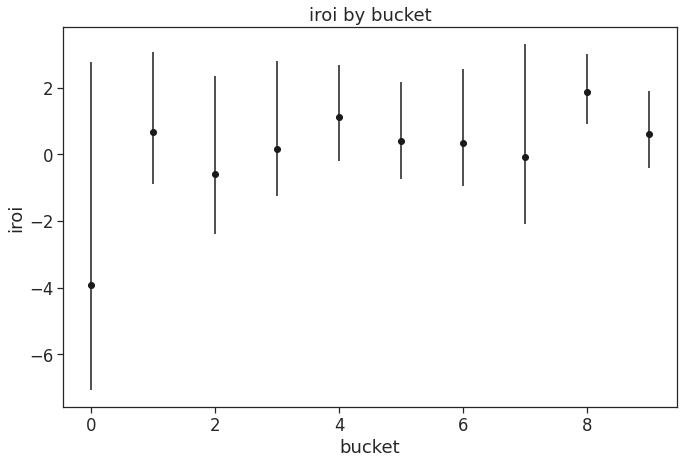

In [18]:
df_barplot, ax = estimate_and_plot_iroi_per_quantile(df_test_eval, 
                                                    n_buckets=10, 
                                                    score_colname='score_re', 
                                                    benefit_colname='benefit',
                                                    cost_colname='cost',
                                                    treatment_colname='treatment', 
                                                    bootstrap=True, 
                                                    n_bootstraps=500)

### Cumulative iROI

No handles with labels found to put in legend.


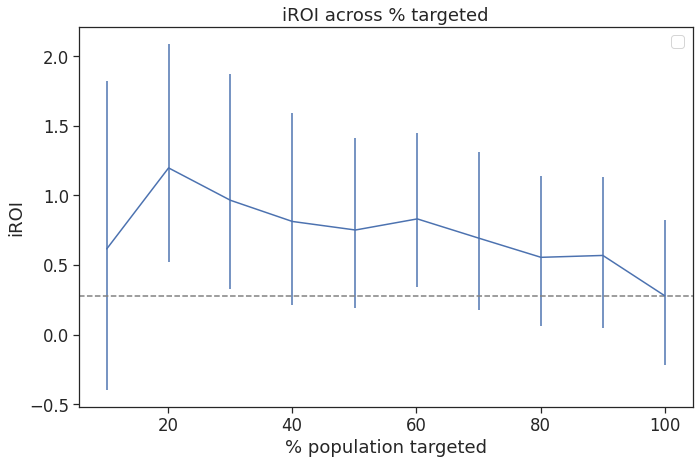

In [19]:
df_iroi, ax = estimate_and_plot_cum_iroi(df_test_eval, 
                                        score_colname='score_re', 
                                        benefit_colname='benefit', 
                                        cost_colname='cost',
                                        treatment_colname='treatment', 
                                        n_buckets=10,
                                        bootstrap=True, 
                                        n_bootstraps=500)

In [20]:
df_iroi

,bucket,count,fraction,threshold,iroi,iroi_lower,iroi_upper,iroi_std_error
0,9.0,50,0.101626,0.617809,0.615834,-0.397535,1.824445,0.572186
1,8.0,99,0.201220,0.590491,1.197815,0.519005,2.087322,0.403547
2,7.0,148,0.300813,0.573419,0.965194,0.325995,1.871686,0.412947
3,6.0,197,0.400407,0.557683,0.813199,0.210219,1.595729,0.349328
4,5.0,247,0.502033,0.543668,0.751770,0.191711,1.411014,0.309225
5,4.0,296,0.601626,0.531338,0.831543,0.342297,1.451241,0.286144
6,3.0,345,0.701220,0.510712,0.692398,0.173922,1.309936,0.279379
7,2.0,394,0.800813,0.493694,0.555487,0.062370,1.140613,0.273152
8,1.0,443,0.900407,0.470596,0.569055,0.048634,1.135021,0.263306
9,0.0,492,1.000000,-inf,0.279548,-0.219864,0.825590,0.272441


#### Plotting with subplots

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'iROI across % targeted'}, xlabel='% population targeted', ylabel='iROI'>

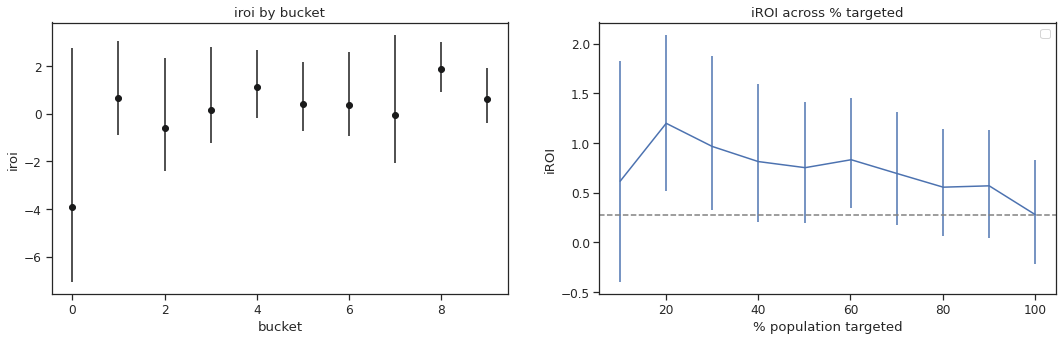

In [21]:
sns.set(font_scale=1.1, style='ticks', rc={'figure.figsize':(18, 5)})

fig, axes = plt.subplots(1, 2)

plot_metric_per_bucket(df_barplot,
                       y='iroi',
                       bootstrap=True, 
                       ax=axes[0])
    
plot_cum_iroi(df_iroi,
              bootstrap=True,
              ax=axes[1])